import the package and Load the data

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

subscription = pd.read_csv('subscription.csv',index_col='user_id')
subscription.head(10)

,subscription_signup_date,subscription_monthly_cost,country,source,billing_cycles,is_active
user_id,,,,,,
1459,"January, 2015",29,Spain,ads,4,0
12474,"January, 2015",49,France,ads,5,0
12294,"January, 2015",49,Germany,ads,2,0
3878,"January, 2015",49,China,ads,1,0
9567,"January, 2015",49,UK,ads,5,0
790,"January, 2015",49,US,ads,3,0
12214,"January, 2015",49,France,ads,1,0
7341,"January, 2015",29,US,ads,8,1
1026,"January, 2015",99,Spain,ads,1,0


del the signup date since evereyone has the same date, this is useless


In [2]:
del subscription['subscription_signup_date']
subscription.head(10)


,subscription_monthly_cost,country,source,billing_cycles,is_active
user_id,,,,,
1459,29,Spain,ads,4,0
12474,49,France,ads,5,0
12294,49,Germany,ads,2,0
3878,49,China,ads,1,0
9567,49,UK,ads,5,0
790,49,US,ads,3,0
12214,49,France,ads,1,0
7341,29,US,ads,8,1
1026,99,Spain,ads,1,0


In [4]:
subscription.isnull().sum()

subscription_monthly_cost    0
country                      0
source                       0
billing_cycles               0
is_active                    0
dtype: int64

In [6]:
subscription.shape

(500000, 5)

Question1. build a model that predicts monthly retention rate for the diﬀerent subscription price points

In [119]:
count_by_cost = subscription.groupby('subscription_monthly_cost').apply(lambda x:x.billing_cycles.value_counts()).unstack()
count_by_cost

,1,2,3,4,5,6,7,8
subscription_monthly_cost,,,,,,,,
29,57441,21818,12037,7787,5505,4136,3111,34527
49,185145,53296,21690,11288,6727,4405,3173,14673
99,44788,4724,1471,678,399,226,156,799


In [120]:
total_by_cost = count_by_cost.transpose().apply(lambda x: x[::-1].cumsum()[::-1])
total_by_cost = total_by_cost/total_by_cost.iloc[0]
total_by_cost

subscription_monthly_cost,29,49,99
1,1.000000,1.000000,1.000000
2,0.607542,0.383666,0.158769
3,0.458473,0.206247,0.070040
4,0.376232,0.134043,0.042411
5,0.323028,0.096466,0.029676
6,0.285416,0.074072,0.022182
7,0.257157,0.059408,0.017937
8,0.235901,0.048845,0.015007


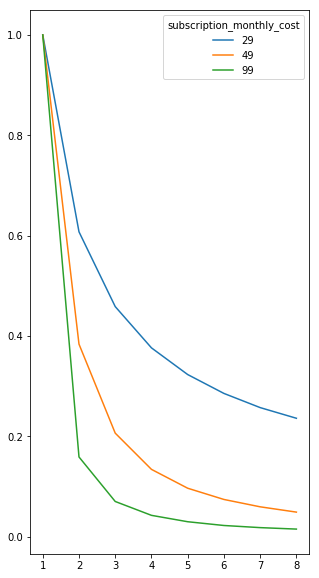

In [121]:
total_by_cost.plot()
plt.show()


fit Linear Regression model¶
from above plot, we can draw following conclusions:

for each 'monthly_cost', there are only 8 samples.
complex model will overfit on samll dataset, so I decide to use a simple regression model - Linear Regression
the remaining #subscribers by the end of each billing cycles has a nonlinear relationship with #billing_cycles
so I need to include some nonlinear transformation of 'billing_cycles'
by no means, the target, #subscribers should be non-negative
so I cannot fit on original target, i.e., '#subscribers at the end of each billing cycle', but on log(#subscribers).
then after obtaining the fitted value, we transform back to '#subscribers' by exp(), which can guarantee the result is always positive

In [29]:
def make_time_feature(t):
    return pd.DataFrame({'t':t,'tlog':np.log(t),'tsquare':t*t},index = t)
def fit_linear_regression(s):
    X = make_time_feature(s.index)
    return LinearRegression().fit(X,np.log(s))

In [30]:
subscription.tail(10)

,subscription_signup_date,subscription_monthly_cost,country,source,billing_cycles,is_active
user_id,,,,,,
493817,"January, 2015",99,UK,ads,1,0
494166,"January, 2015",49,UK,ads,1,0
487240,"January, 2015",49,India,ads,1,0
486795,"January, 2015",99,Spain,seo,1,0
482155,"January, 2015",49,US,ads,1,0
496962,"January, 2015",29,Spain,ads,2,0
480669,"January, 2015",29,Italy,seo,1,0
491164,"January, 2015",29,UK,ads,2,0
493323,"January, 2015",49,Germany,ads,1,0


In [31]:
LR_by_cost = total_by_cost.apply(fit_linear_regression,axis = 0)
LR_by_cost

subscription_monthly_cost
29    LinearRegression(copy_X=True, fit_intercept=Tr...
49    LinearRegression(copy_X=True, fit_intercept=Tr...
99    LinearRegression(copy_X=True, fit_intercept=Tr...
dtype: object

predict on billing cycles from 9~12
because

there are so few examples (only 8) for each model. we cannot afford to split out a separate test set, which will further reduce the data used for training
the question is predicting near future, cycles from 9 to 12, which I assume there is no significant difference from our training data.
due to above two considerations, I don't use normal cross validation to check how my model fits, but just plot the true values and my predictions to visualize how my model fits.

In [33]:
time_range = np.arange(1,13)
time = make_time_feature(time_range)
time

,t,tlog,tsquare
1,1,0.000000,1
2,2,0.693147,4
3,3,1.098612,9
4,4,1.386294,16
5,5,1.609438,25
6,6,1.791759,36
7,7,1.945910,49
8,8,2.079442,64
9,9,2.197225,81
10,10,2.302585,100


In [123]:
predicts = LR_by_cost.apply(lambda x: pd.Series(x.predict(time),index = time_range)).transpose()
predicts = predicts.apply(lambda x: np.exp(x))
predicts

subscription_monthly_cost,29,49,99
1,146289.043583,301551.603773,52816.489536
2,89078.661927,113569.323151,8700.570325
3,67048.510837,62560.448086,3678.850952
4,54997.715283,40592.309531,2210.169591
5,47259.987332,28988.345871,1567.465186
6,41802.132010,22106.115832,1208.305347
7,37703.792361,17713.678002,968.806877
8,34484.309114,14771.777457,786.979952
9,31866.862280,12740.560957,636.784748
10,29680.233950,11317.105659,507.336931


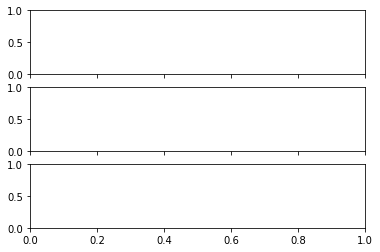

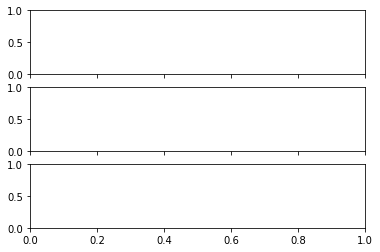

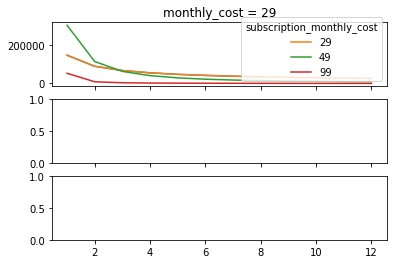

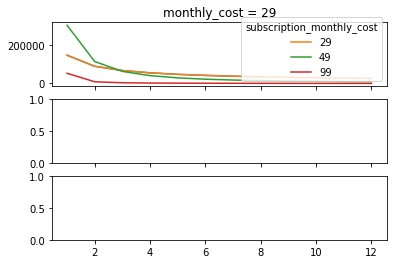

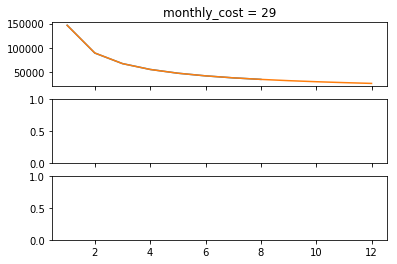

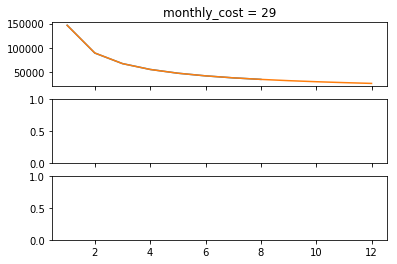

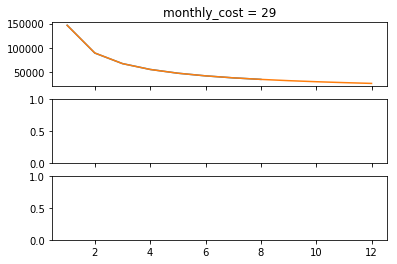

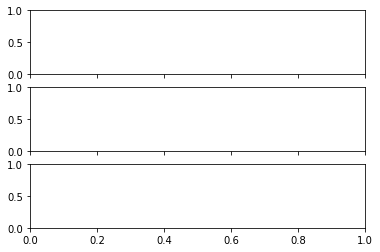

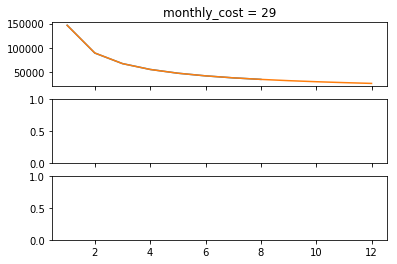

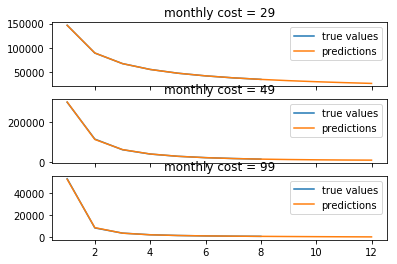

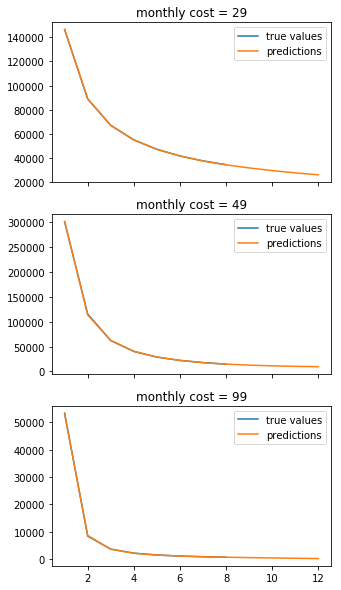

In [56]:
fig,axes = plt.subplots(3,1,sharex=True)
monthly_costs = [29,49,99]
for index,cost in enumerate(monthly_costs):
    ax = axes[index]
    total_by_cost.loc[:,cost].plot(ax = ax,label='true values')
    predicts.loc[:,cost].plot(ax=ax,label='predictions')
    ax.legend(loc='best')
    ax.set_title('monthly cost = {}'.format(cost))
plt.rc('figure',figsize=(5,10))
plt.show()


In [59]:
true_vs_predict = pd.merge(total_by_cost,predicts,how = 'right',left_index = True,right_index = True, suffixes=('_true','_pred'))
true_vs_predict

subscription_monthly_cost,29_true,49_true,99_true,29_pred,49_pred,99_pred
1,146362.0,300397.0,53241.0,146289.043583,301551.603773,52816.489536
2,88921.0,115252.0,8453.0,89078.661927,113569.323151,8700.570325
3,67103.0,61956.0,3729.0,67048.510837,62560.448086,3678.850952
4,55066.0,40266.0,2258.0,54997.715283,40592.309531,2210.169591
5,47279.0,28978.0,1580.0,47259.987332,28988.345871,1567.465186
6,41774.0,22251.0,1181.0,41802.132010,22106.115832,1208.305347
7,37638.0,17846.0,955.0,37703.792361,17713.678002,968.806877
8,34527.0,14673.0,799.0,34484.309114,14771.777457,786.979952
9,NaN,NaN,NaN,31866.862280,12740.560957,636.784748
10,NaN,NaN,NaN,29680.233950,11317.105659,507.336931


Based on your model, for each price point, what percentage of users is still subscribed after at least 12 months?

In [77]:
rate = predicts.loc[12,:]/predicts.loc[1,:]
rate

subscription_monthly_cost
29    0.179014
49    0.031984
99    0.005644
dtype: float64

In [96]:
def calculation_rate(s):
    s = s.iloc[::-1].cumsum().iloc[::-1]
    return s/s.iloc[0]
def rentention_rate_by(colname):
    counts = subscription.groupby(colname).apply(lambda x:x.billing_cycles.value_counts()).unstack().transpose()
    return calculation_rate(counts)


In [97]:
rentention_by_country = rentention_rate_by('country')
rentention_by_country

country,China,France,Germany,India,Italy,Spain,UK,US
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,0.514831,0.334946,0.451284,0.446728,0.341684,0.339098,0.458938,0.456509
3,0.402777,0.177732,0.278411,0.326962,0.179502,0.178985,0.285133,0.284255
4,0.360426,0.119004,0.195910,0.284527,0.119914,0.119879,0.198067,0.198853
5,0.336274,0.088479,0.146474,0.261603,0.090015,0.088648,0.149421,0.149284
6,0.319856,0.069935,0.115151,0.246736,0.071135,0.070065,0.117356,0.117398
7,0.307084,0.058341,0.093868,0.234847,0.057523,0.057617,0.095735,0.094875
8,0.295453,0.049688,0.078465,0.225769,0.048695,0.048503,0.079494,0.078981


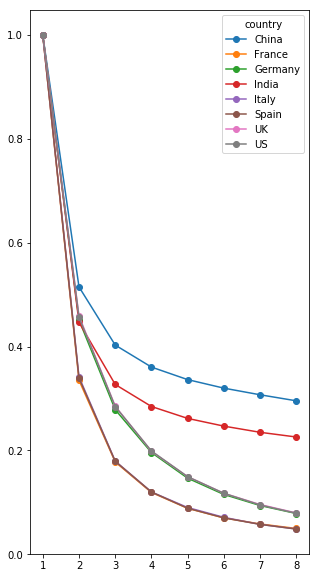

In [124]:
rentention_by_country.plot(marker = 'o')
plt.show()

In [114]:
rentention_by_country.iloc[-1,:].sort_values(ascending=False)

country
China      0.295453
India      0.225769
UK         0.079494
US         0.078981
Germany    0.078465
France     0.049688
Italy      0.048695
Spain      0.048503
Name: 8, dtype: float64

based on above result, we can divide coutries into 3 classes:

customers from China and Indian are most loyal ones.
not only retention rate is high, but also the 'dropping rate' is the slowest
this may be because the good economic situations in these two countries, and also because rich people in these two countries love buying foreign products to show their 'social class'.
to increase the revenue, we should keep tight touch to customers in China and Indian. for examples, sending coupons to them from time to time.
UK, US, Germany has medium 'retention rate'
France, Italy, Spain has the lowest 'retention rate'
maybe because the poor economic conditions in these countries
we may consider to lower the 'monthly cost' in these countries, to keep more customers in subscription


In [115]:
rentention_by_source = rentention_rate_by('source')
rentention_by_source

source,ads,friend_referral,seo
1,1.000000,1.000000,1.000000
2,0.388873,0.699443,0.562395
3,0.222094,0.617038,0.420012
4,0.152607,0.561282,0.337594
5,0.114959,0.519854,0.286254
6,0.092043,0.487596,0.247877
7,0.076756,0.461110,0.218680
8,0.066237,0.436507,0.194475


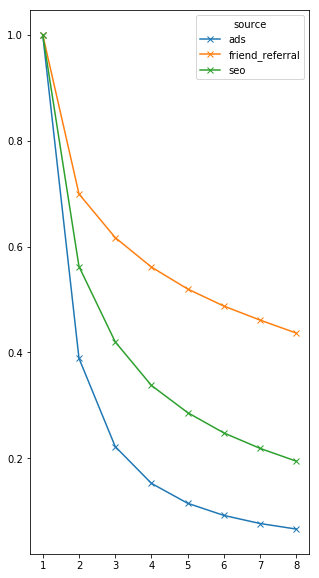

In [117]:
rentention_by_source.plot(marker='x')
plt.show()

from above result, we can see that subscribers from 'friend_referral' are the loyalest, much more loyal then subscribers from advertisement and search engine.

To improve the revenue, we can launch some program to improve 'user referral'. for example, current subscribers can invite new users to subscribe. if your friends subscribe, you get rewarded with a certain amount of money or credit